In [1]:
import numpy as np
import matplotlib.pyplot as plt
from EMAN2 import *
from sklearn.decomposition import PCA
import scipy.spatial.distance as scipydist

In [2]:
#### select one GPU when multiple GPUs are present
os.environ["CUDA_VISIBLE_DEVICES"]='1' 

#### do not occupy the entire GPU memory at once
##   seems necessary to avoid some errors...
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true' 

#### finally initialize tensorflow
import tensorflow as tf


In [3]:
#### we will import some functions from e2gmm_refine later
emdir=e2getinstalldir()
sys.path.insert(0,os.path.join(emdir,'bin'))

#### need to unify the float type across tenforflow and numpy
##   in theory float16 also works but it can be unsafe especially when the network is deeper...
floattype=np.float32

In [4]:
#### load particles and prepare some parameters
from e2gmm_refine_new import *
fname="r3d_00/ptcls_01.lst"

##  Fourier box size. will shrink particles accordingly
maxboxsz=72 

##   load metadata first
e=EMData(fname, 0, True)
raw_apix, raw_boxsz = e["apix_x"], e["ny"]
data_cpx, xfsnp = load_particles(fname, maxboxsz, shuffle=False)

print("Image size: ", data_cpx[0].shape)

##   set up fourier indices for image generation/clipping later
##   params is a dictionay that saves matrices for Fourier indexing
apix=raw_apix*raw_boxsz/maxboxsz
clipid=set_indices_boxsz(data_cpx[0].shape[1], apix, True)
params=set_indices_boxsz(maxboxsz)

##   create an empty options object that is needed for some functions in e2gmm_refine
options=type('options', (object,), {})()
options.sym="c1"


Loading 3000 particles of box size 128. shrink to 72
 2000/3000    R     R     3000/3000
Data read complete
Image size:  (3000, 72, 37)


In [5]:
#### load the Gaussian model produced by e2gmm_refine.py
pts=np.loadtxt("gmm_00/model_gmm.txt").astype(floattype)
print("Gaussian model shape: ", pts.shape)

##   turn model to tensorflow format
pts=tf.constant(pts[None,:,:])


Gaussian model shape:  (1519, 5)


0.23110871


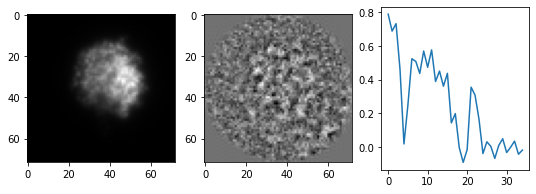

In [6]:
#### now generate some images to make sure everything is working properly
sz=params["sz"]    ## size of image
bsz=8              ## batch size

##   generate a batch of projection images from the GMM at neutral state
##   pts2img produce complex images in (real, imag) format
##   turn them into complex numbers and IFT to get the real images
ptsx=tf.Variable(tf.repeat(pts, bsz, axis=0))
imgs_real, imgs_imag=pts2img(ptsx, xfsnp[:bsz])
imgs_cpx=imgs_real.numpy().astype(floattype)+1j*imgs_imag.numpy().astype(floattype)
imgs_out=np.fft.irfft2(imgs_cpx)

##   just show one projection-particle comparison
ii=1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(np.fft.ifftshift(imgs_out[ii]), cmap='gray')

##   get the complex particle image and IFT to real space
dcpx=(data_cpx[0][:bsz], data_cpx[1][:bsz])
dcpx=get_clip(dcpx, sz, clipid)
dcpx_out=np.fft.irfft2(dcpx[0].numpy()+1j*dcpx[1].numpy())

plt.subplot(1,3,2)
plt.imshow(np.fft.ifftshift(dcpx_out[ii]), cmap='gray')

##   calculate FRC between particle and projection
##   the calc_frc function takes complex images in (real, imag) format
frc=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"], True)
plt.subplot(1,3,3)
plt.plot(frc[ii][1:])
fval=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"])
print(np.mean(fval))

 375/375 : 0.2018         mean score: 0.210


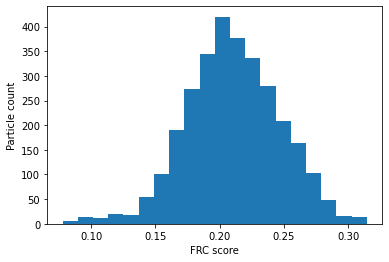

In [7]:
#### calculate d(FRC)/d(GMM) for each particle
##   this will be the input for the deep network in place of the particle images
##   shrink particles to the requested size
options.minpx=2
options.maxpx=maxboxsz//2
options.normgrad=True
dcpx=get_clip(data_cpx, params["sz"], clipid)

##   prepare training set to be fed into the function
trainset=tf.data.Dataset.from_tensor_slices((dcpx[0], dcpx[1], xfsnp))
trainset=trainset.batch(bsz)
allscr, allgrds=calc_gradient(trainset, pts, params, options)

##   histogram FRC for each particle
plt.hist(allscr, 20);
plt.xlabel("FRC score");
plt.ylabel("Particle count");

In [8]:
##   parse parameters as options
options.niter=20                ## number of iterations
options.pas=[0,1,0]             ## mask the (position, amplitude, sigma) of the GMM during training
options.learnrate=1e-5          ## learning rate
ptclidx=allscr>-1               ## this allows the selection of a subset of particles for training. now used now
options.anchor=None
options.perturb=0.1
options.rigidbody=None
options.usetest=True
bsz=32
nmid=4     ## size of latent space
conv=False  

##   actual training
trainset=tf.data.Dataset.from_tensor_slices((allgrds[ptclidx], dcpx[0][ptclidx], dcpx[1][ptclidx], xfsnp[ptclidx]))
trainset=trainset.batch(bsz)

npt=pts.shape[1]
imsk=tf.zeros(npt, dtype=floattype)+1

In [9]:
## start from the baseline. this is just 3 dense layers 

##   build the actual network
encode_model=build_encoder(nout=nmid, conv=conv)
decode_model=build_decoder(pts[0].numpy(), ninp=nmid, conv=conv)

##   test the network to make sure they are function properly
##   before training, they should output GMMs that are very close to the neutral GMM
mid=encode_model(allgrds[:bsz])
print("Latent space shape: ", mid.shape)
out=decode_model(mid)
print("Output shape: ",out.shape)
print("Deviation from neutral model: ", np.mean(abs(out-pts)))

Latent space shape:  (32, 4)
Output shape:  (32, 1519, 5)
Deviation from neutral model:  0.00020033606


In [10]:
train_heterg(trainset, pts, encode_model, decode_model, params,imsk, options);

iter 0, train loss : -0.2103; test loss -0.2037
iter 1, train loss : -0.2092; test loss -0.2071
iter 2, train loss : -0.2103; test loss -0.2072
iter 3, train loss : -0.2097; test loss -0.2071
iter 4, train loss : -0.2100; test loss -0.2073
iter 5, train loss : -0.2101; test loss -0.2073
iter 6, train loss : -0.2106; test loss -0.2073
iter 7, train loss : -0.2108; test loss -0.2073
iter 8, train loss : -0.2107; test loss -0.2065
iter 9, train loss : -0.2109; test loss -0.2000
iter 10, train loss : -0.2111; test loss -0.2074
iter 11, train loss : -0.2112; test loss -0.2077
iter 12, train loss : -0.2113; test loss -0.2078
iter 13, train loss : -0.2102; test loss -0.2079
iter 14, train loss : -0.2113; test loss -0.2079
iter 15, train loss : -0.2116; test loss -0.2082
iter 16, train loss : -0.2120; test loss -0.2081
iter 17, train loss : -0.2120; test loss -0.2083
iter 18, train loss : -0.2114; test loss -0.2086
iter 19, train loss : -0.2125; test loss -0.2088


(3000, 4)


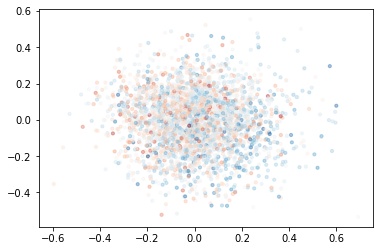

In [11]:
#### compute the conformation of each particle

##   this is a 4D latent space and can be hard to visualize
mid=calc_conf(encode_model, allgrds[ptclidx])
print(mid.shape)
plt.scatter(mid[:,0], mid[:,1], mid[:,2]+10, mid[:,3]+1, alpha=.4, cmap="RdBu");

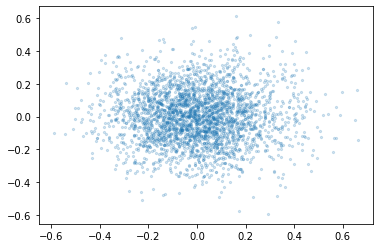

In [12]:


pca=PCA(2)
p2=pca.fit_transform(mid)
plt.scatter(p2[:,0], p2[:,1],s=5,  alpha=.2);


In [13]:
decode_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_5 (Dense)             (None, 512)               2560      
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                             

(1519, 3)
(1024, 3)
(512, 3)
(256, 3)
(128, 3)
(64, 3)


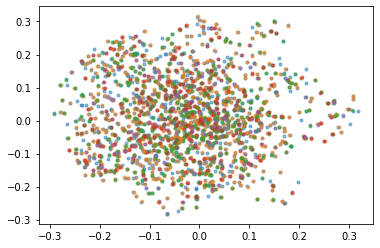

In [14]:
bsz=20
gd=allgrds[:bsz]
pt0=pts[0,:,:3].numpy().copy()
plt.plot(pt0[:,0], pt0[:,1],'.', alpha=.5)
print(pt0.shape)
ptpool=[pt0]
nlayer=5
pns=[64*2**i for i in range(nlayer)][::-1]
# pns=[len(pt0)//(2**i)//32*16 for i in range(nlayer)]
# pns[-1]=64
for i in range(nlayer):
    pn=pns[i]
    
    pt1=pt0.copy()
    np.random.shuffle(pt1)
    pt1=pt1[:pn,:]
    pt1+=np.random.randn(len(pt1),3)*1e-3

    plt.plot(pt1[:,0], pt1[:,1],'.', alpha=.5)
    print(pt1.shape)
    ptpool.append(pt1.copy())
    
# ptpool.append(pt1.copy())    
nlayer=len(ptpool)-1

In [15]:

nnb=16
dstid0=[]
dstid1=[]
for li in range(nlayer):
    dst01=scipydist.cdist(ptpool[li], ptpool[li+1])
    di=np.argsort(dst01, axis=0)[:nnb].T
    dstid0.append(di)
    
    dj=np.argsort(dst01, axis=1)[:,:nnb]
    dstid1.append(dj)
    print(li, di.shape, dj.shape)
    

0 (1024, 16) (1519, 16)
1 (512, 16) (1024, 16)
2 (256, 16) (512, 16)
3 (128, 16) (256, 16)
4 (64, 16) (128, 16)


In [16]:
# y1=gd
kinit=tf.keras.initializers.RandomNormal(0,1e-7)
l2=tf.keras.regularizers.l2(1e-3)

x0=tf.keras.Input(shape=(gd.shape[1:]))
y1=x0
print(y1.shape)
k0=y1.shape[2]
k1s=[256]*nlayer
k1s[0]/=4
k1s[-1]/=4
for li in range(nlayer):
    k1=k1s[li]
    ly=tf.keras.layers.Dense(k1,kernel_regularizer=l2)#, kernel_initializer=kinit)
    y0=ly(y1)
    
    y1=tf.gather(y0, dstid0[li], axis=1)
    # y1=tf.reduce_mean(y1, axis=2)
    y1=tf.reduce_sum(y1, axis=2)
    y1=tf.nn.relu(y1)
    y1=tf.keras.layers.Dropout(.1)(y1)
    
    y1=tf.keras.layers.BatchNormalization()(y1)
    print(li, y0.shape, y1.shape)

    
midshape=y1.shape[1:]
y2=tf.keras.layers.Flatten()(y1)
print(y2.shape)
y2=tf.keras.layers.Dropout(.3)(y2)
y2=tf.keras.layers.BatchNormalization()(y2)
y2=tf.keras.layers.Dense(nmid, kernel_initializer=kinit)(y2)
print(y2.shape)

encode_model=tf.keras.Model(x0, y2)

(None, 1519, 4)
0 (None, 1519, 64) (None, 1024, 64)
1 (None, 1024, 256) (None, 512, 256)
2 (None, 512, 256) (None, 256, 256)
3 (None, 256, 256) (None, 128, 256)
4 (None, 128, 64) (None, 64, 64)
(None, 4096)
(None, 4)


In [17]:

x0=tf.keras.Input(shape=(4))
y1=x0
print(y1.shape)

y1=tf.keras.layers.Dense(np.prod(midshape))(y1)
y1=tf.keras.layers.Reshape(midshape)(y1)
print(y1.shape)
    
print('---------')
k1s=[256]*nlayer
k1s[-1]=5
for li in range(nlayer):
    k1=k1s[li]
    if li==nlayer-1:
        ly=tf.keras.layers.Dense(k1,kernel_regularizer=l2, kernel_initializer=kinit)
    else:
        ly=tf.keras.layers.Dense(k1,kernel_regularizer=l2)
    # ly=tf.keras.layers.Dense(k1,kernel_regularizer=l2)#, kernel_initializer=kinit)
    y0=ly(y1)
    
    y1=tf.gather(y0, dstid1[nlayer-li-1], axis=1)
    # y1=tf.reduce_mean(y1, axis=2)
    y1=tf.reduce_sum(y1, axis=2)
    
    if li==nlayer-1: 
        y1=tf.math.tanh(y1)
    else:
        y1=tf.nn.relu(y1)
        y1=tf.keras.layers.Dropout(.1)(y1)
        y1=tf.keras.layers.BatchNormalization()(y1)
        
    # if li==nlayer-2:
    #     y1=tf.keras.layers.Dropout(.3)(y1)
    print(li, y0.shape, y1.shape)
    
# bshift=np.array([-.5,-.5,-.5,0,.5]).astype(floattype)
y2=y1+pts#+tf.constant(bshift)
decode_model=tf.keras.Model(x0, y2)

(None, 4)
(None, 64, 64)
---------
0 (None, 64, 256) (None, 128, 256)
1 (None, 128, 256) (None, 256, 256)
2 (None, 256, 256) (None, 512, 256)
3 (None, 512, 256) (None, 1024, 256)
4 (None, 1024, 5) (None, 1519, 5)


In [18]:
# decode_model=build_decoder(pts[0].numpy(), ninp=nmid, conv=conv)

m=encode_model(gd)
print(m.shape, np.mean(m), np.std(m))
o=decode_model(m)
print(o.shape,o[0,0], np.std(o))

(20, 4) 0.01593924 0.019174704
(20, 1519, 5) tf.Tensor([-0.23685108 -0.09058314  0.10514931  0.80539966  0.99421287], shape=(5,), dtype=float32) 0.4027533


In [19]:
# wts=encode_model.trainable_variables[4:]+decode_model.trainable_variables[:-4]

In [20]:
# options.perturb=.1
npt=pts.shape[1]
pas=[int(i) for i in options.pas]
pas=tf.constant(np.array([pas[0],pas[0],pas[0],pas[1],pas[2]], dtype=floattype))

## initialize optimizer
opt=tf.keras.optimizers.Adam(learning_rate=options.learnrate)
# opt=tf.keras.optimizers.SGD(learning_rate=options.learnrate)
wts=encode_model.trainable_variables + decode_model.trainable_variables
nbatch=0
for t in trainset: nbatch+=1

# Training
allcost=[]
for itr in range(20):

    i=0
    cost=[]
    testcost=[]
    for grd,pjr,pji,xf in trainset:
        pj_cpx=(pjr, pji)
        with tf.GradientTape() as gt:
            ## from gradient input to the latent space
            conf=encode_model(grd, training=True)

            ## regularization of the latent layer range
            ## ideally the output is within a 1-radius circle
            ## but we want to make the contraint more soft so it won't affect convergence
            cl=tf.math.sqrt(tf.reduce_sum(conf**2, axis=1))
            cl=tf.reduce_mean(tf.maximum(cl-1,0))


            ## perturb the conformation by a random value
            ## similar to the variational autoencoder,
            ## but we do not train the sigma of the random value here
            ## since we control the radius of latent space already, this seems enough
            conf=options.perturb*tf.random.normal(conf.shape)+conf		# 0.1 is a pretty big perturbation for this range, maybe responsible for the random churn in the models? --steve

            ## mask out the target columns based on --pas
            pout=decode_model(conf, training=True)
            p0=tf.zeros((xf.shape[0],npt, 5))+pts

            if options.rigidbody:
                pout=rotpts(p0[:,:,:3], pout, imsk) 
                pout=tf.concat([pout, p0[:,:,3:]], axis=2)

            pout=pout*pas+p0*(1-pas)

            ## mask selected rows
            pout=pout*imsk[None,:,None]+p0*(1-imsk[None,:,None]) 

            ## finally generate images and calculate frc
            imgs_cpx=pts2img(pout, xf)
            fval=calc_frc(pj_cpx, imgs_cpx, params["rings"], minpx=options.minpx, maxpx=options.maxpx)
            loss=-tf.reduce_mean(fval)+cl*.1

            #if options.modelreg>0: 
                #loss+=tf.reduce_sum((pout[:,:,:3]-pts[:,:,:3])**2)/len(pts)/xf.shape[0]*options.modelreg

        if options.usetest==False or len(cost)<nbatch*.95:
            cost.append(loss)
            grad=gt.gradient(loss, wts)
            opt.apply_gradients(zip(grad, wts))
        else:
            testcost.append(loss)

        i+=1
        if i%10==0: 
            sys.stdout.write("\r {}/{}\t{:.3f}         ".format(len(cost), nbatch, loss))
            sys.stdout.flush()

    sys.stdout.write("\r")
    if options.usetest:
        print("iter {}, train loss : {:.4f}; test loss {:.4f}".format(itr, np.mean(cost), np.mean(testcost)))
    else:
        print("iter {}, loss : {:.4f}, {:.4f}".format(itr, np.mean(cost), cl))
    allcost.append(np.mean(cost))

iter 0, train loss : -0.2166; test loss -0.2172
iter 1, train loss : -0.2235; test loss -0.2213
iter 2, train loss : -0.2267; test loss -0.2236
iter 3, train loss : -0.2289; test loss -0.2256
iter 4, train loss : -0.2305; test loss -0.2265
iter 5, train loss : -0.2318; test loss -0.2277
iter 6, train loss : -0.2329; test loss -0.2290
iter 7, train loss : -0.2338; test loss -0.2297
iter 8, train loss : -0.2345; test loss -0.2305
iter 9, train loss : -0.2351; test loss -0.2303
iter 10, train loss : -0.2355; test loss -0.2312
iter 11, train loss : -0.2360; test loss -0.2316
iter 12, train loss : -0.2364; test loss -0.2321
iter 13, train loss : -0.2368; test loss -0.2321
iter 14, train loss : -0.2372; test loss -0.2321
iter 15, train loss : -0.2374; test loss -0.2326
iter 16, train loss : -0.2376; test loss -0.2330
iter 17, train loss : -0.2379; test loss -0.2332
iter 18, train loss : -0.2380; test loss -0.2337
iter 19, train loss : -0.2383; test loss -0.2336


(3000, 4)


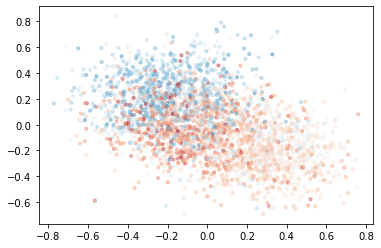

In [21]:

##   this is a 4D latent space and can be hard to visualize
mid=calc_conf(encode_model, allgrds[ptclidx], bsz=100)
print(mid.shape)
plt.scatter(mid[:,0], mid[:,1], mid[:,2]+10, mid[:,3]+1, alpha=.4, cmap="RdBu");

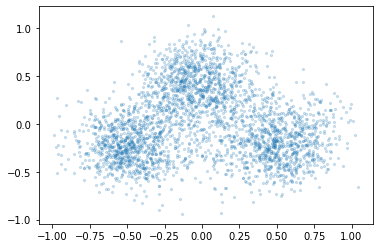

In [22]:

from sklearn.decomposition import PCA
pca=PCA(2)
p2=pca.fit_transform(mid)
plt.scatter(p2[:,0], p2[:,1],s=5,  alpha=.2);

In [24]:
decode_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_14 (Dense)            (None, 4096)              20480     
                                                                 
 reshape_1 (Reshape)         (None, 64, 64)            0         
                                                                 
 dense_15 (Dense)            (None, 64, 256)           16640     
                                                                 
 tf.compat.v1.gather_5 (TFOp  (None, 128, 16, 256)     0         
 Lambda)                                                         
                                                                 
 tf.math.reduce_sum_5 (TFOpL  (None, 128, 256)         0         
 ambda)                                                    